In [1]:
from bubblewrap import Bubblewrap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/miles/.local/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/miles/.local/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


## Generate some data

In [ ]:
%env TF_CPP_MIN_LOG_LEVEL=0


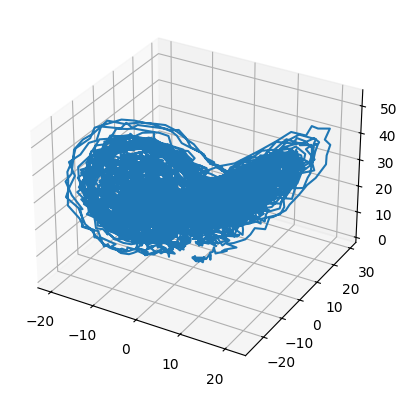

In [2]:
generator = np.random.default_rng()

def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

sigma1 = 0.75#*np.cos(np.linspace(0,1,len(xyzs))*10*np.pi)[:,None]
sigma2 = 1.5#*np.cos(np.linspace(0,1,len(xyzs))*10*np.pi)[:,None]
noise = sigma1 *generator.normal(size=xyzs.shape)


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.plot(xyzs[:,0],xyzs[:,1],xyzs[:,2],linewidth=0.5)
ax.plot(xyzs[:,0]+noise[:,0],xyzs[:,1]+noise[:,1],xyzs[:,2]+noise[:,2])#,alpha=0.25)
plt.show()
plt.close()

In [3]:

def bubblewrap_data(data):
    
    N = 1000             # number of nodes to tile with
    lam = 1e-3          # lambda 
    nu = 1e-3           # nu
    eps = 1e-3          # epsilon sets data forgetting
    step = 8e-2         # for adam gradients
    
    B_thresh = -10      # threshold for when to teleport (log scale)    
    batch = True       # run in batch mode 
    
    go_fast = True     # flag to skip computing priors, predictions, and entropy for optimal speed
    future_distance = 1

    T = data.shape[0]      
    d = data.shape[1]       # should be 3

    M = T//100              # small set of data seen for initialization
    batch_size = T//100      # batch mode size; if not batch is 1
    
    bw = Bubblewrap(N, d, step=step, lam=lam, M=M, eps=eps, nu=nu, B_thresh=B_thresh, batch=batch, batch_size=batch_size, go_fast=go_fast, future_distance=future_distance)

    #print('initializing bubblewrap...')
    step = batch_size
    for i in np.arange(0, M, step): 
        bw.observe(data[i:i+step])
    bw.init_nodes()
    #print(f"{np.sum(np.isnan(bw.L))} nan values in L")
    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for i in np.arange(init, end, step): #,desc='fitting bubblewrap....'):
        future_index = i+M+step - 2 + bw.future_distance
        future_x = data[future_index] if future_index < ((end- 1) + M ) else None
    
        bw.observe(data[i+M:i+M+step], future_x=future_x)
        bw.e_step()  
        bw.grad_Q()
        nNan = np.sum(np.isnan(bw.L))
        if nNan > 0:
            print(f"after iter {i+1}, {nNan} nans in L")

    return bw

def update_bubblewrap(bw,data):

    T = data.shape[0]      
    d = data.shape[1]
    M = T//100              # small set of data seen for initialization
    batch_size = T//100      # batch mode size; if not batch is 1

    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for i in np.arange(init, end, step): #,desc='fitting bubblewrap....'):
        future_index = i+M+step - 2 + bw.future_distance
        future_x = data[future_index] if future_index < ((end- 1) + M ) else None
    
        bw.observe(data[i+M:i+M+step], future_x=future_x)
        bw.e_step()  
        bw.grad_Q(mode='update')
        nNan = np.sum(np.isnan(bw.L))
        if nNan > 0:
            print(f"after iter {i+1}, {nNan} nans in L")

    return bw
    

    

In [4]:
nIters = 50
bw = bubblewrap_data(xyzs)
bound_noiseless = bw.get_fisher_ub()
print(bound_noiseless)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


6.7110004


In [5]:
bounds_noisy = []
for noiseLevel in np.arange(0.25,10.3,1.):
    print(f"Noise level: {noiseLevel}")
    sigma = noiseLevel#*np.cos(np.linspace(0,1,len(xyzs))*10*np.pi)[:,None]
    noiseBounds = []
    for iter in tqdm(range(nIters),desc = f"simulating for noise sd: {noiseLevel}"):
        #print(iter,end=", ")
        noise = sigma *generator.normal(size=xyzs.shape)
        bwNoise = update_bubblewrap(bw,xyzs + noise)
        noiseBounds.append(bwNoise.get_fisher_ub())
    bounds_noisy.append(noiseBounds)

Noise level: 0.25


simulating for noise sd: 0.25: 100%|█| 


Noise level: 1.25


simulating for noise sd: 1.25: 100%|█| 


Noise level: 2.25


simulating for noise sd: 2.25: 100%|█| 


Noise level: 3.25


simulating for noise sd: 3.25: 100%|█| 


Noise level: 4.25


simulating for noise sd: 4.25: 100%|█| 


Noise level: 5.25


simulating for noise sd: 5.25: 100%|█| 


Noise level: 6.25


simulating for noise sd: 6.25: 100%|█| 


Noise level: 7.25


simulating for noise sd: 7.25: 100%|█| 


Noise level: 8.25


simulating for noise sd: 8.25: 100%|█| 


Noise level: 9.25


simulating for noise sd: 9.25: 100%|█| 


Noise level: 10.25


simulating for noise sd: 10.25: 100%|█|


In [6]:
bounds_noisy_cos = []
for noiseLevel in np.arange(0.25,10.3,1.):
    print(f"Noise level: {noiseLevel}")
    sigma = noiseLevel*np.cos(np.linspace(0,1,len(xyzs))*10*np.pi)[:,None]
    noiseBounds = []
    for iter in tqdm(range(nIters),desc = f"simulating for noise sd: {noiseLevel}"):
        #print(iter,end=", ")
        noise = sigma *generator.normal(size=xyzs.shape)
        bwNoise = update_bubblewrap(bw,xyzs + noise)
        noiseBounds.append(bwNoise.get_fisher_ub())
    bounds_noisy_cos.append(noiseBounds)

Noise level: 0.25


simulating for noise sd: 0.25: 100%|█| 


Noise level: 1.25


simulating for noise sd: 1.25: 100%|█| 


Noise level: 2.25


simulating for noise sd: 2.25: 100%|█| 


Noise level: 3.25


simulating for noise sd: 3.25: 100%|█| 


Noise level: 4.25


simulating for noise sd: 4.25: 100%|█| 


Noise level: 5.25


simulating for noise sd: 5.25: 100%|█| 


Noise level: 6.25


simulating for noise sd: 6.25: 100%|█| 


Noise level: 7.25


simulating for noise sd: 7.25: 100%|█| 


Noise level: 8.25


simulating for noise sd: 8.25: 100%|█| 


Noise level: 9.25


simulating for noise sd: 9.25: 100%|█| 


Noise level: 10.25


simulating for noise sd: 10.25: 100%|█|


In [7]:
#bounds_noisy = [[b.get_fisher_ub() for b in bws] for bws in bwNoises]
#print(bounds_noisy)
muBs = [np.nanmean(b) for b in bounds_noisy]
seBs = [np.nanstd(b)/len(b) for b in bounds_noisy]
muBsC = [np.nanmean(b) for b in bounds_noisy_cos]
seBsC = [np.nanstd(b)/len(b) for b in bounds_noisy_cos]

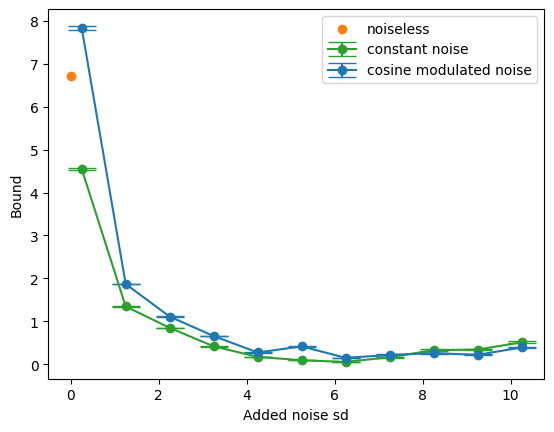

In [8]:
ax = plt.gca()
ax.scatter([0],[bound_noiseless],color='tab:orange',label='noiseless')
ax.errorbar(np.arange(0.25,10.3,1.),muBs,yerr=seBs,fmt='-o',capsize=10,color='tab:green',label='constant noise')
ax.errorbar(np.arange(0.25,10.3,1.),muBsC,yerr=seBsC,fmt='-o',capsize=10,color='tab:blue',label='cosine modulated noise')
ax.set_xlabel("Added noise sd")
ax.set_ylabel("Bound")
#ax.set_title("Constant noise")
plt.legend()
plt.savefig("./boundByAddedNoises_samemeans.png")
plt.show()
plt.close()